# Running Probabilistic MDF on *i*CH360

In [28]:
import cobra
from cobra.flux_analysis import pfba
import gurobipy as gp
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import sys
sys.path.append('../../utils/')
import visualisation_utils
import pickle

## Load COBRA model

In [29]:
model=cobra.io.read_sbml_model('../../Model/iCH360/Escherichia_coli_iCH360.xml')
model.reactions.get_by_id('EX_glc__D_e').lower_bound=0

'' is not a valid SBML 'SId'.


## Load Thermodynamics estimates

In [30]:
# DrG0 prime mean, adjusted for multi-compartment reactions 
drg0_prime_mean=pd.read_csv('../../Thermodynamics/free_energy_estimates/drg0_estimates/drg0_prime_mean_mcc.csv',index_col=0).squeeze()

# DrG0 prime covariance matrix (full columns rank Square root)
drg0_prime_cov_sqrt=pd.read_csv('../../Thermodynamics/free_energy_estimates/drg0_estimates/drg0_cov_sqrt.csv',index_col=0)

# DrG0 prime covariance matrix
drg0_prime_cov=pd.read_csv('../../Thermodynamics/free_energy_estimates/drg0_estimates/drg0_cov_df.csv',index_col=0)


The covariance square root $Q$ is a $n$ x $q$ matrix, where $n$ is the number of reactions in the covariance matrix $C$ and $q \leq n$ is the rank of $C$, such that:
$$
C=QQ^T
$$
Let's verify this as a sanity check

In [31]:
(drg0_prime_cov_sqrt@drg0_prime_cov_sqrt.T-drg0_prime_cov).abs().max().max()

2.874375362615922e-05

# Formulate the MDF problem
Here we formulate the following LP, corresponding to the probabilistic MDF problem, in gurobi. See our paper for more details on this formulation!

$$
\max_{\mathbf{m},b} \hspace{0.1cm} b\\
    \hspace{0.5cm}    \Delta_rG'^o=\bar{{\Delta_rG'^o}}+Q \mathbf{m} \hspace{1.5cm} (1)\\
    \hspace{0.5cm}    ||\mathbf{m}||_2^2=\mathbf{m}^T\mathbf{m}\ \leq \chi^2_{q;\alpha} \hspace{1.5cm} (2)\\ 
    \hspace{0.5cm}    \Delta_rG'=\Delta_rG'^o+RT S^T \mathbf{c}\hspace{1.2cm} (3)\\
    \hspace{0.5cm}    \mathbf{L_c}\leq\mathbf{c}\leq\mathbf{U_c}\hspace{2.9cm} (4)\\
    \hspace{0.5cm}    -\text{sign}(v_i) \Delta_rG'_i >b, \hspace{0.5cm} \text{if  } v_i \neq 0\hspace{0.3cm} (5)\\
$$

where:
- $Q$ is the square root of the covariance matrix, with size $n$ x $q$
- $\mathbf{m}$ is $q$ dimensional vector, and is used to account for uncertainty in the estimates
- $\bar{{\Delta_rG'^o}}$ is the mean estimate of the free reaction energies
- $\chi^2_{q;\alpha}$ is the PPF (percent point function) of a $\chi^2$ distribution with $q$ degrees of freedom, evaluated at $\alpha$
- $\alpha$ is the desired confidence level (e.g. $0.95$)
- $\mathbf{c}$ is a vector of log-metabolite concentrations, with upper and lower bounds $\mathbf{L_c}$ and $\mathbf{U_c}$, respectively
- $S$ is the stoichiometric matrix
- $v_i$ are the components of the reference flux vector $\mathbf{v}$, for which we want to compute the MDF

In [32]:
# Define a function to construct the MDF problem
def construct_mdf_problem(drg0_prime_mean:pd.Series,
                          drg0_prime_cov_sqrt:pd.DataFrame,
                          v:pd.Series,
                          S:pd.DataFrame,
                          concentration_custom_bounds=dict(),
                          default_concentration_lb=0.001,
                          default_concentration_ub=10,
                          alpha:float=0.95,
                          nonzero_flux_thresh=1e-8,
                          T=310.15):

    """
    Formulate the MDF problem described above in Gurobi
    Args:
    drg0_prime_mean: pd.Series, the mean estimates for the standard free energies of reaction
    drg0_prime_cov_sqrt: pd.DataFrame, the square root of the covariance matrix of the standard trfree energies of reaction
    v: pd.Series, the reference flux vector for which the MDF is to be calculated
    S: pd.DataFrame, the stoichiometric matrix
    concentration_custom_bounds: dict, a dictionary of custom concentration bounds (in mM) for specific metabolites, in the form of {met_id:(lb,ub)}
    default_concentration_lb: float, the lower bound for the concentration of metabolites (in mM), for metabolites not included in concentration_custom_bounds
    default_concentration_ub: float, the upper bound for the concentration of metabolites (in mM), for metabolites not included in concentration_custom_bounds
    alpha: float, the confidence level for the probabilistic adjustment of the mean DrG0 estimates 
    nonzero_flux_thresh: float, a flux is considered non-zero if its absolute value is greater than this threshold
    T: float, the temperature in Kelvin used for the calculation of the free energies of reaction
    """
    #Sanity checks
    assert drg0_prime_mean.index.equals(drg0_prime_cov_sqrt.index)
    #Define reactions which should be subject to thermodynamic constraints, and create the corresponding stoichiometric matrix and flux vector
    thermo_reactions=drg0_prime_mean.index.tolist()
    S_thermo=S.loc[:,thermo_reactions]
    v_thermo=v.loc[thermo_reactions]

    #parse relevant quantities
    n=S_thermo.shape[1] #number of thermodynamically constrained reactions
    n_mets=S_thermo.shape[0] #number of metabolites
    q=drg0_prime_cov_sqrt.shape[1] #rank of the covariance matrix
    R=8.31446261815324e-3 #gas constant in kJ/(K*mol)
    #====================================================
    #===================================================
    #Create a Gurobi model
    mdf_problem=gp.Model()
    # Define the probabilistic detachment from the mean, vector m, and constrain its squared norm
    m=mdf_problem.addMVar((q,1))
    chi2_bound=scipy.stats.chi2(q).ppf(alpha) #bound for the squared norm of m
    m_constraint=mdf_problem.addConstr(m.T@m<=chi2_bound) #Constraint (2)
    # Define the probabilistically adjusted DrG'0
    DrG0_prime=mdf_problem.addMVar((n,1),name='DrG0_prime',lb=-np.inf,ub=np.inf)
    mdf_problem.addConstr(DrG0_prime==drg0_prime_mean.values.reshape(-1,1)+drg0_prime_cov_sqrt.values@m) #Constraint (1)
    # Define the concentration vector, and constrain the bound of each metabolite (Eq. 4)
    ln_c=mdf_problem.addMVar((n_mets,1),lb=-np.inf,ub=np.inf,name='ln_c')
    for i in range(n_mets):
        cur_met_id=S_thermo.index[i]
        if cur_met_id in concentration_custom_bounds.keys():
            lb=np.log(concentration_custom_bounds[cur_met_id][0])
            ub=np.log(concentration_custom_bounds[cur_met_id][1])
        else:
            lb=np.log(default_concentration_lb)
            ub=np.log(default_concentration_ub)
            
        mdf_problem.addConstr(ln_c[i,0]>=lb,name=f'lb_{cur_met_id}')
        mdf_problem.addConstr(ln_c[i,0]<=ub,name=f'ub_{cur_met_id}')
    # Define free energy of reactions (Eq 3)
    DrG_prime=mdf_problem.addMVar((n,1),name='DrG_prime',lb=-np.inf,ub=np.inf)
    mdf_problem.addConstr(DrG_prime==DrG0_prime+R*T*S_thermo.values.T@ln_c)
    #Constraint the driving force of each reaction to be at least b, if the reaction carries non-zero flux
    b=mdf_problem.addVar(lb=-np.inf,name='b')
    #Note that we set the lower bound of b to be -inf, so that b<=0 implies a thermodynamically infeasible flux distribution
    for i in range(n):
        cur_reaction_id=thermo_reactions[i]
        cur_v=v_thermo[i]

        #Constraint (5):
        if np.abs(cur_v)>nonzero_flux_thresh:
            assert np.sign(cur_v)!=0
            mdf_problem.addConstr(-np.sign(cur_v)*DrG_prime[i,0]>=b,name=f'drg_{cur_reaction_id}')
    # Define the objective function
    mdf_problem.setObjective(b,sense=gp.GRB.MAXIMIZE)
    mdf_problem.setParam('QCPDual',1) #This is required to get the shadow prices since the problem is a QCP
    mdf_problem.setParam('BarQCPConvTol',1e-9)
    
    return mdf_problem,{'S_thermo':S_thermo,'v_thermo':v_thermo}





# The next function is simply solving the model
def solve_and_postprocess(mdf_problem:gp.Model,
                          drg0_prime_mean:pd.Series,
                          drg0_prime_cov_sqrt:pd.DataFrame,
                          S_thermo:pd.DataFrame,
                          v:pd.Series,
                          nonzero_flux_thresh=1e-8):
    """
    Solve the MDF problem and postprocess the results
    Args:
    mdf_problem: gp.Model, the MDF problem
    S_thermo: pd.DataFrame, the stoichiometric matrix used in the MDF problem (i.e. only including thermodynamically constarined reactions)
    v: pd.Series, the reference flux vector for which the MDF was calculated
    """
    #Solve the problem
    mdf_problem.optimize()

    #Postprocess the results
    n_rxns=S_thermo.shape[1]
    n_mets=S_thermo.shape[0]
    #Extract shadow prices. This sometimes fail due to the crazy coefficients in the QCP problem, in this case we just assign them to NaN
    drg_shadow_prices=[]
    for i in range(n_rxns):
        try:
            drg_shadow_prices.append(mdf_problem.getConstrByName(f'drg_{S_thermo.columns[i]}').Pi)
        except:
            drg_shadow_prices.append(np.nan)

    lb_shadow_prices=[]
    ub_shadow_prices=[]
    for i in range(n_mets):
        try:
            lb_shadow_prices.append(mdf_problem.getConstrByName(f'lb_{S_thermo.index[i]}').Pi)
            ub_shadow_prices.append(mdf_problem.getConstrByName(f'ub_{S_thermo.index[i]}').Pi)
        except:
            lb_shadow_prices.append(np.nan)
            ub_shadow_prices.append(np.nan)

    # 1. Optimised concentrations
    mdf_concentrations=pd.DataFrame(index=S_thermo.index,
                       data={'optimised_conc_mM':np.exp([mdf_problem.getVarByName(f'ln_c[{i},0]').X for i in range(n_mets)]),
                             'shadow_price_lb':lb_shadow_prices,
                            'shadow_price_ub':ub_shadow_prices
                            }
                       )
    #2. Optimised driving forces
    drg0_prime_cov=drg0_prime_cov_sqrt@drg0_prime_cov_sqrt.T
    v_thermo=v.loc[S_thermo.columns]
    v_thermo[v_thermo.abs()<nonzero_flux_thresh]=0
    

    
        

    mdf_driving_forces=pd.DataFrame(index=S_thermo.columns,
                                data={'drg0_prime_mean_kJ_mol':drg0_prime_mean.values,
                                      'drg0_prime_std':np.sqrt(np.diag(drg0_prime_cov)),
                                      'adjusted_drg0_prime':[mdf_problem.getVarByName(f'DrG0_prime[{i},0]').X for i in range(n_rxns)],
                                      'driving_force_kJ_mol':[mdf_problem.getVarByName(f'DrG_prime[{i},0]').X * np.sign(v_thermo[i]) for i in range(n_rxns)],
                                      'driving_force_shadow_price':drg_shadow_prices,
                                      'flux':v_thermo.values
                                     }
                                )
    
    mdf=mdf_problem.getObjective().getValue()
    return mdf,mdf_concentrations,mdf_driving_forces
    



## Test: Aerobic growth on glucose

In [33]:
with model:
  model.reactions.get_by_id('EX_glc__D_e').lower_bound=-10
  S=cobra.util.array.create_stoichiometric_matrix(model,'DataFrame')
  reference_flux_distribution=pfba(model).fluxes
  mdf_problem,problem_data=construct_mdf_problem(drg0_prime_mean= drg0_prime_mean,
                                    drg0_prime_cov_sqrt=drg0_prime_cov_sqrt,
                                    v=reference_flux_distribution,
                                    S=S,
                                    concentration_custom_bounds={})
  mdf,mdf_concentrations,mdf_driving_forces=solve_and_postprocess(mdf_problem=mdf_problem, 
                                                            drg0_prime_mean=drg0_prime_mean,
                                                              drg0_prime_cov_sqrt=drg0_prime_cov_sqrt,
                                                               S_thermo=problem_data['S_thermo'],
                                                               v=reference_flux_distribution)

                              

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Set parameter QCPDual to value 1
Set parameter BarQCPConvTol to value 1e-09
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 1454 rows, 1105 columns and 32154 nonzeros
Model fingerprint: 0x6d7d186c
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e-13, 1e+05]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-07, 3e+02]
  QRHS range       [2e+02, 2e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1025 rows and 494 columns
Presolve time: 0.02s
Presolved: 605 rows, 612 columns, 23168 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Free vars

In [35]:
mdf_concentrations.head()

,optimised_conc_mM,shadow_price_lb,shadow_price_ub
dhap_c,0.070514,-0.000000,0.0
prbatp_c,0.098944,-0.000000,0.0
10fthf_c,0.002293,-0.000000,0.0
co2_e,0.001000,-0.000693,0.0
akg_e,0.001000,-0.000296,0.0


In [36]:
mdf_driving_forces.head()

,drg0_prime_mean_kJ_mol,drg0_prime_std,adjusted_drg0_prime,driving_force_kJ_mol,driving_force_shadow_price,flux
NDPK5,1.404247,2.405183,-1.770507,-22.653262,-1.671085e-11,0.023387
SHK3Dr,-3.945072,1.311172,-4.436398,-14.724747,-3.493100e-11,0.328942
NDPK6,-1.116819,1.276840,-3.080979,-23.329045,-1.599954e-11,0.022650
NDPK8,2.470122,1.468695,0.521972,-21.442159,-1.815761e-11,0.022650
DHORTS,-10.159996,1.692716,-11.620204,-7.503734,-4.995944e-09,-0.286345


We can verify that the probabilistic ajustment of the standard free energies only significantly affected those reactions with very high uncertainty

c:\Users\marco\miniconda3\envs\kinetic_data\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


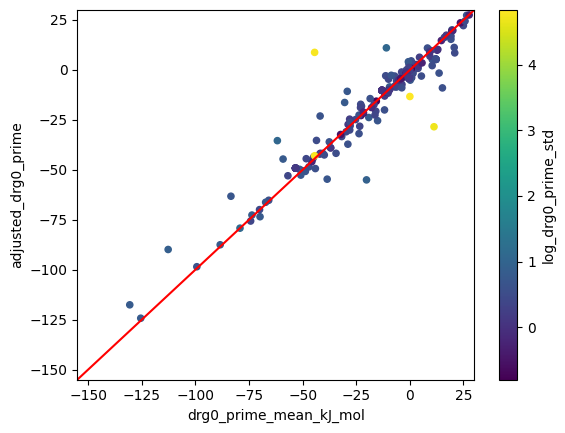

In [37]:
mdf_driving_forces['log_drg0_prime_std']=np.log10(mdf_driving_forces['drg0_prime_std'])
ax=mdf_driving_forces.query('flux!=0').plot(x='drg0_prime_mean_kJ_mol',y='adjusted_drg0_prime',c='log_drg0_prime_std',kind='scatter')
ax.set_xlim(-155,30)
ax.set_ylim(-155,30)
ax.axline((1, 1), slope=1,c='red')


# Repeat across growth conditions

In [38]:
model.reactions.get_by_id('EX_glc__D_e').lower_bound=0

carbon_sources=['glc__D','lac__D','ac','pyr' ,'glyc','xyl__D','akg','rib__D','succ','fum']
exchange_fluxes=['EX_'+c_source+'_e' for c_source in carbon_sources]
conditions=['aerobic','anaerobic']
results={cs:{condition:{'mdf':None,'concentrations':None,'driving_forces':None} for condition in conditions}for cs in carbon_sources} 
for i,carbon_source in enumerate(carbon_sources):
    for condition in conditions:
      with model:
        print(f'Calculating MDF for {carbon_source} {condition}')
        print("=====================================")
        model.reactions.get_by_id(exchange_fluxes[i]).lower_bound=-10
        if condition=='anaerobic':
           if carbon_source in ['glc__D','rib__D','xyl__D']:
              model.reactions.get_by_id('EX_o2_e').lower_bound=0
           else:
              results[carbon_source][condition]=None
              continue
        reference_flux_distribution=pfba(model).fluxes
        mdf_problem,problem_data=construct_mdf_problem(drg0_prime_mean= drg0_prime_mean,
                                      drg0_prime_cov_sqrt=drg0_prime_cov_sqrt,
                                      v=reference_flux_distribution,
                                      S=S,
                                      concentration_custom_bounds={})
        mdf_problem.setParam('OutputFlag',0)
        mdf,mdf_concentrations,mdf_driving_forces=solve_and_postprocess(mdf_problem=mdf_problem, 
                                                                drg0_prime_mean=drg0_prime_mean,
                                                                  drg0_prime_cov_sqrt=drg0_prime_cov_sqrt,
                                                                  S_thermo=problem_data['S_thermo'],
                                                                  v=reference_flux_distribution)
        
        results[carbon_source][condition]['mdf']=mdf
        results[carbon_source][condition]['concentrations']=mdf_concentrations
        results[carbon_source][condition]['driving_forces']=mdf_driving_forces

        

Calculating MDF for glc__D aerobic
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter QCPDual to value 1
Set parameter BarQCPConvTol to value 1e-09
Calculating MDF for glc__D anaerobic
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter QCPDual to value 1
Set parameter BarQCPConvTol to value 1e-09
Calculating MDF for lac__D aerobic
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter QCPDual to value 1
Set parameter BarQCPConvTol to value 1e-09
Calculating MDF for lac__D anaerobic
Calculating MDF for ac aerobic
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter QCPDual to value 1
Set parameter BarQCPConvTol to value 1e-09
Calculating MDF for ac anaerobic
Calculating MDF for pyr aerobic
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter QCPDual to value 1
Set parameter BarQCPConvTol to va

In [39]:
print("MDF results")
print("============")
for carbon_source in carbon_sources:
    for condition in conditions:
        if results[carbon_source][condition] is not None:
            print(f'MDF for {carbon_source} - {condition}: {results[carbon_source][condition]["mdf"]} kJ/mol')

MDF results
MDF for glc__D - aerobic: 7.452995397786744 kJ/mol
MDF for glc__D - anaerobic: 2.9833681812705017 kJ/mol
MDF for lac__D - aerobic: 6.181061838061408 kJ/mol
MDF for ac - aerobic: 6.140544541150289 kJ/mol
MDF for pyr - aerobic: 6.181061838148067 kJ/mol
MDF for glyc - aerobic: 6.767540465113183 kJ/mol
MDF for xyl__D - aerobic: 7.452995398140951 kJ/mol
MDF for xyl__D - anaerobic: 2.9833681807164236 kJ/mol
MDF for akg - aerobic: 6.181061840213847 kJ/mol
MDF for rib__D - aerobic: 7.452995397072714 kJ/mol
MDF for rib__D - anaerobic: 2.9833681774712364 kJ/mol
MDF for succ - aerobic: 6.14054454169864 kJ/mol
MDF for fum - aerobic: 6.140544541088697 kJ/mol


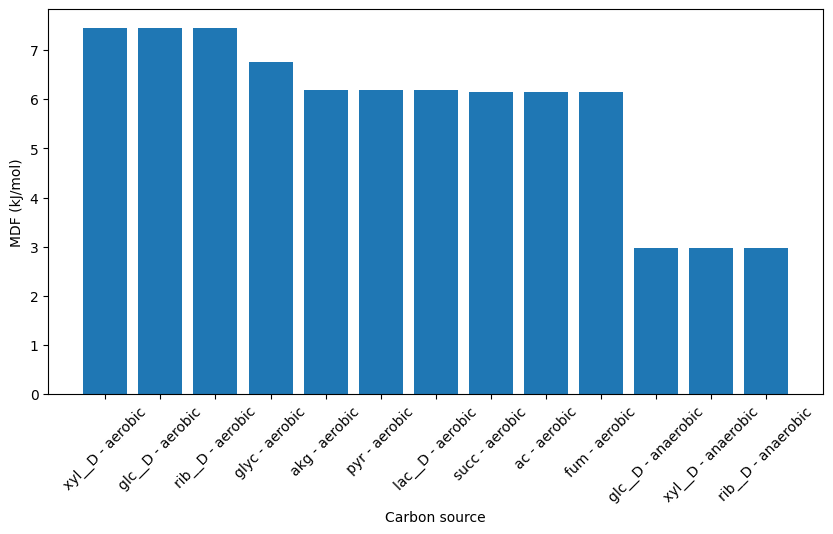

In [40]:
mdf_results=[]
results_labels=[]
for cs in carbon_sources:
    for condition in conditions:
        if results[cs][condition] is not None:
            mdf_results.append(results[cs][condition]['mdf'])
            results_labels.append(f'{cs} - {condition}')
fig,ax=plt.subplots(figsize=(10,5))
#order
sorted_ixs=np.flip(np.argsort(mdf_results))
sorted_mdf_results=np.array(mdf_results)[sorted_ixs]
sorted_results_labels=np.array(results_labels)[sorted_ixs]
#

ax.bar(sorted_results_labels,sorted_mdf_results)
ax.set_ylabel('MDF (kJ/mol)')
ax.set_xlabel('Carbon source')
ax.tick_params(axis='x',labelrotation=45)


Export the results for plotting in the relevant notebook 

In [41]:
for cs in results.keys():
    for condition in conditions:
        if results[cs][condition] is not None:
            results[cs][condition]['driving_forces'].to_csv(f'./out/mdf_driving_forces_{cs}_{condition}.csv')
            results[cs][condition]['concentrations'].to_csv(f'./out/mdf_concentrations_{cs}_{condition}.csv')
with open('out/mdf_all_results.pkl','wb') as f:
    pickle.dump(results,f)

c:\Users\marco\miniconda3\envs\kinetic_data\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
